In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
%load_ext google.colab.data_table

Authenticated


### Ustalenie funkcji dla modelu to inżynieria funkcji i do tego celu eksploruje dane w celu znalezienia funkcji

In [ ]:
%%bigquery --project empik-ga360

SELECT
    start_station_name,
    AVG(duration) AS duration
FROM `bigquery-public-data.london_bicycles.cycle_hire`
GROUP BY start_station_name
limit 5

,start_station_name,duration
0,"Serpentine Car Park, Hyde Park",1920.295582
1,"Speakers' Corner 1, Hyde Park",3710.466127
2,"Queen Street 2, Bank",979.783577
3,"Teviot Street, Poplar",1953.467181
4,"Wandsworth Rd, Isley Court, Wandsworth Road",1503.623323


- Czas wypożyczenia rowerów różni się od stacji

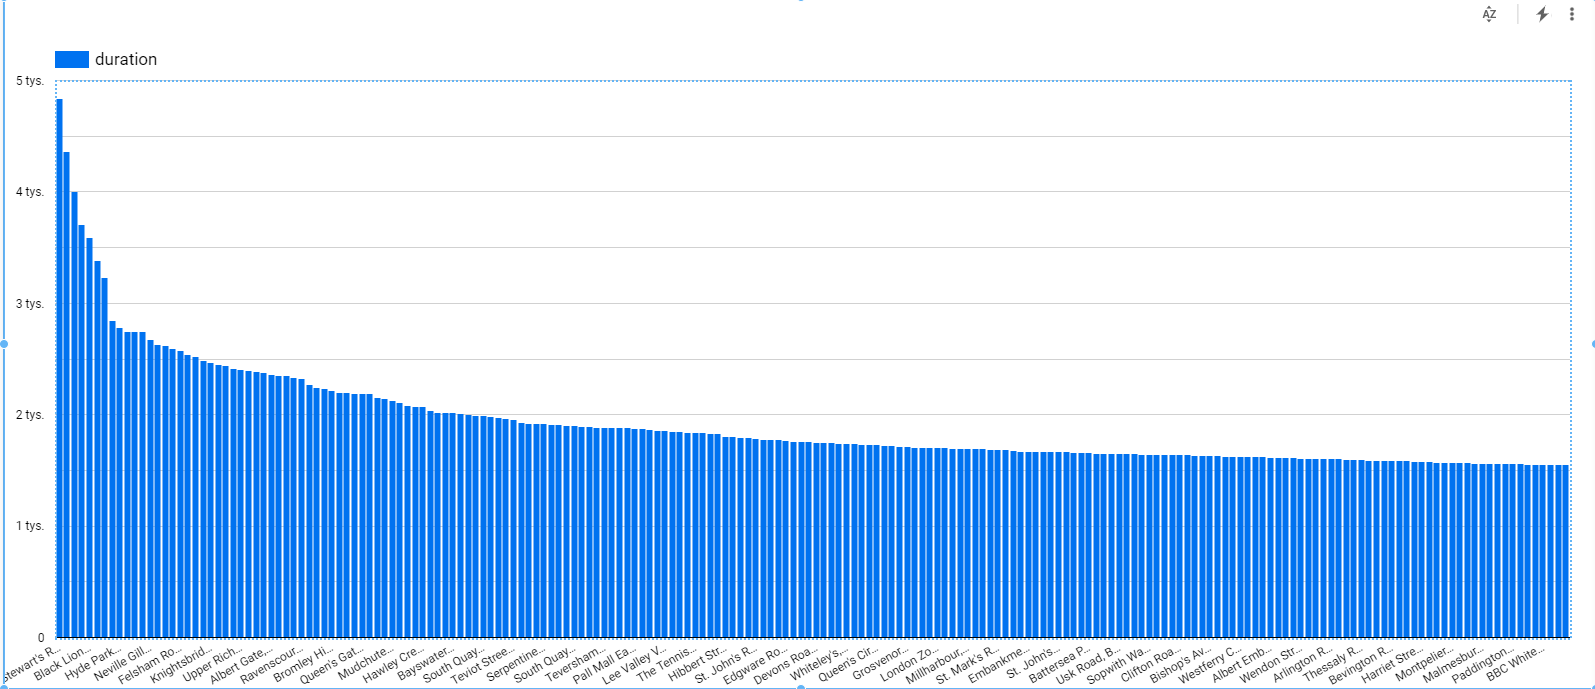

In [ ]:
%%bigquery --project empik-ga360

SELECT
  EXTRACT(dayofweek FROM start_date) AS dayofweek,
  AVG(duration) AS duration
FROM `bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY dayofweek
limit 5

,dayofweek,duration
0,5,1190.617767
1,1,1866.445302
2,6,1253.651453
3,7,1754.172989
4,2,1188.622889


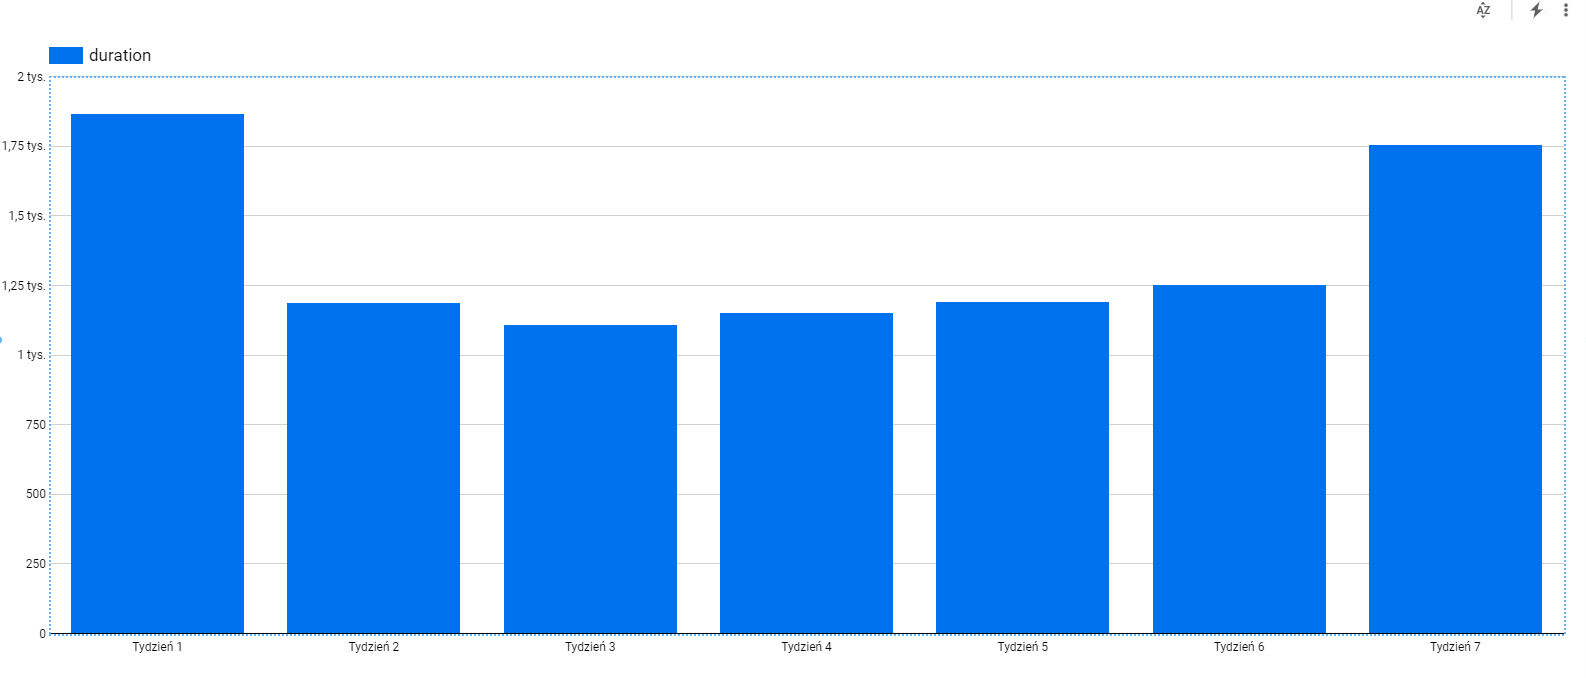

In [ ]:
%%bigquery --project empik-ga360

SELECT
  EXTRACT(hour FROM start_date) AS hour,
  AVG(duration) AS duration
FROM `bigquery-public-data.london_bicycles.cycle_hire`
GROUP BY hour
limit 5

,hour,duration
0,11,1560.743994
1,9,1045.294114
2,17,1253.381830
3,3,2388.941185
4,6,939.913277


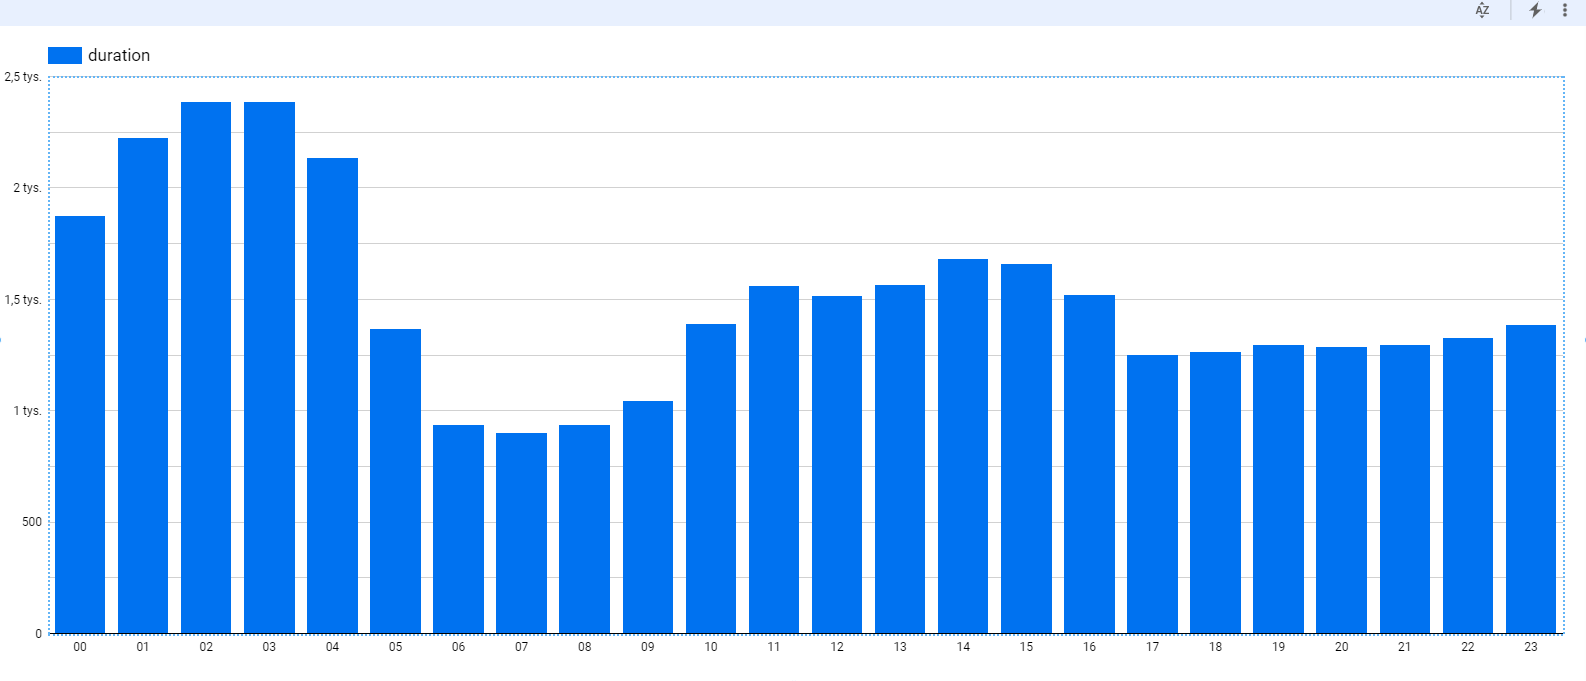

In [ ]:
%%bigquery --project empik-ga360

SELECT
  bikes_count, AVG(duration) AS duration
FROM `bigquery-public-data.london_bicycles.cycle_hire` h
JOIN `bigquery-public-data.london_bicycles.cycle_stations` s
ON h.start_station_name = s.name
GROUP BY bikes_count
limit 5

,bikes_count,duration
0,5,1570.916562
1,2,1215.044509
2,19,1334.216703
3,18,1332.779666
4,1,1279.965440


- Liczba rowerów w stosunku do czasu wypożyczenia nie ma korelacji. Dane są zaszumione w związku z czym etykieta liczby rowerów nie jest dobra

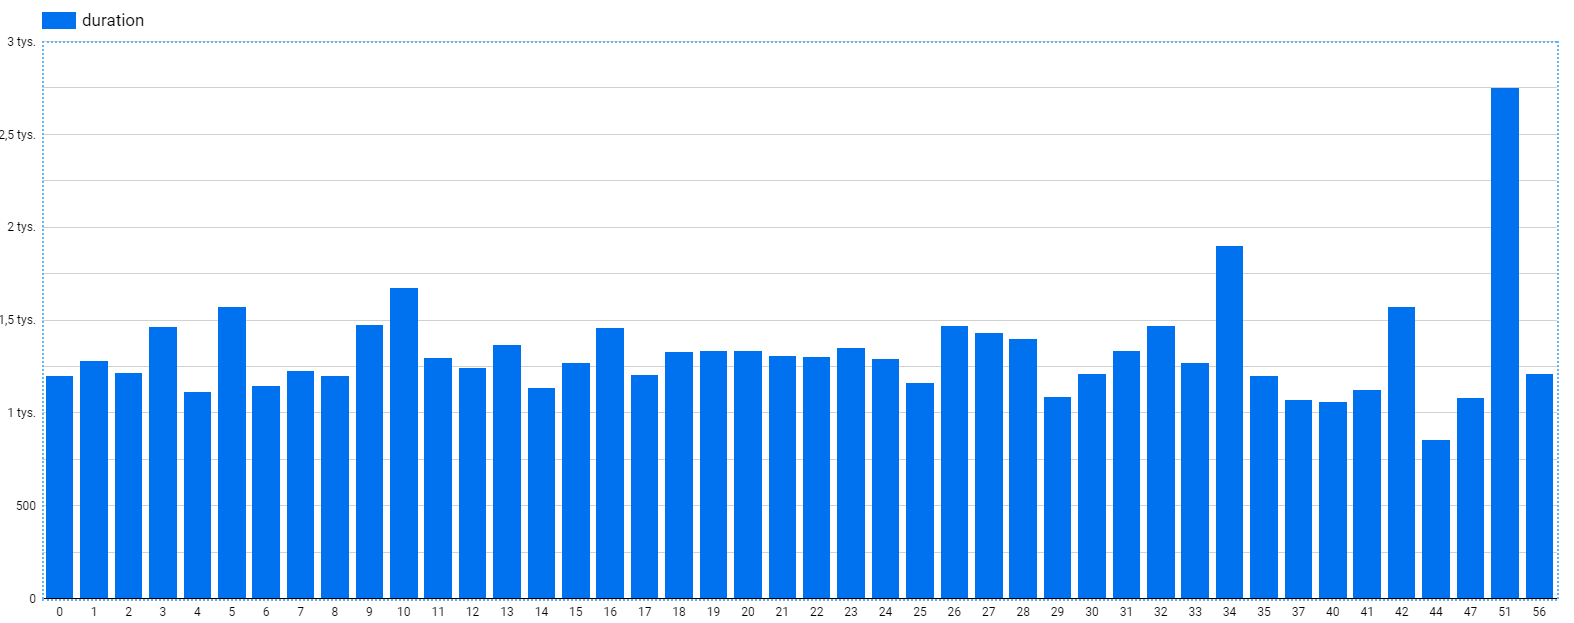

- Zwraca `współczynnik korelacji Pearsona` zestawu par liczb. Dla każdej pary liczb pierwsza liczba jest zmienną zależną, a druga liczba jest zmienną niezależną. Zwracany wynik jest między -1 i 1. Wynik wskazuje na brak korelacji.

In [ ]:
%%bigquery --project empik-ga360

SELECT
  corr(bikes_count, duration) corr
FROM `bigquery-public-data.london_bicycles.cycle_hire` h
JOIN `bigquery-public-data.london_bicycles.cycle_stations` s
ON h.start_station_name = s.name

,corr
0,0.000942


### Tworzę tabelę
`cycle_hire`

In [ ]:
%%bigquery --project empik-ga360

SELECT
  duration
  , start_station_name
  , CAST(EXTRACT(dayofweek FROM start_date) AS STRING) as dayofweek
  , CAST(EXTRACT(hour FROM start_date) AS STRING) AS hourofday
FROM `bigquery-public-data.london_bicycles.cycle_hire`
limit 5

,duration,start_station_name,dayofweek,hourofday
0,600,"Philpot Street, Whitechapel",1,13
1,540,"Aldersgate Street, Barbican",6,18
2,2040,"Sedding Street, Sloane Square",5,9
3,5760,"Harriet Street, Knightsbridge",1,12
4,900,"Abbey Orchard Street, Westminster",5,12


### Tworzenie modelu:

- Model nr 1

In [ ]:
%%bigquery --project empik-ga360

CREATE OR REPLACE MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model`
OPTIONS(
    input_label_cols=['duration'],
    model_type='linear_reg')
AS

SELECT
  duration
  , start_station_name
  , dayofweek
  , hourofday
FROM `empik-ga360.pmackowka_other_analyzes.cycle_hire`

""


- `Średni błąd bezwzględny (MAE)` wynosi 1025 sekund czyli ok. 17 min. co oznacza,  mogę przewidzieć czas trwania wypożyczeń rowerów ze średnim błędem 17 min.  

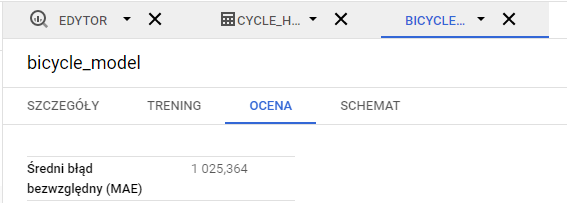

- Oprócz patrzenia na zakładkę oceny mogę sprawdzić wyniki oceny uruchamiając zapytanie:

In [ ]:
%%bigquery --project empik-ga360

SELECT * FROM ML.EVALUATE(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model`)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1025.364041,1.862628e+08,0.862452,542.043498,0.003625,0.003646


- Modyfikuję model konwertując `funkcję dayofweek`, aby sklasyfikować czy dzień to weekend, czy dzień roboczy. Wynika to z tego ponieważ na początkowym etapie eksploracji danych widziałem zależność czasu wynajmu w stosunku do dni tygodnia.
- Model nr 2

In [ ]:
%%bigquery --project empik-ga360

CREATE OR REPLACE MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_weekday`
OPTIONS(
    input_label_cols=['duration'],
    model_type='linear_reg')
AS

SELECT
  duration
  , start_station_name
  , case when dayofweek in ('7','0') then 'weekend' else 'weekday' end dayofweek
  , hourofday
FROM `empik-ga360.pmackowka_other_analyzes.cycle_hire`

""


- W ten sposób poprawiłem `Średni błąd bezwzględny (MAE)`

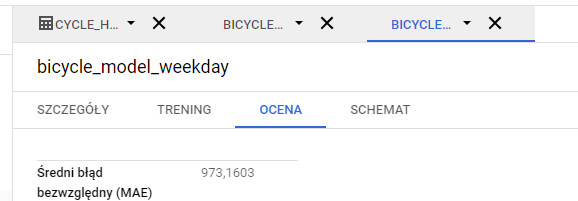

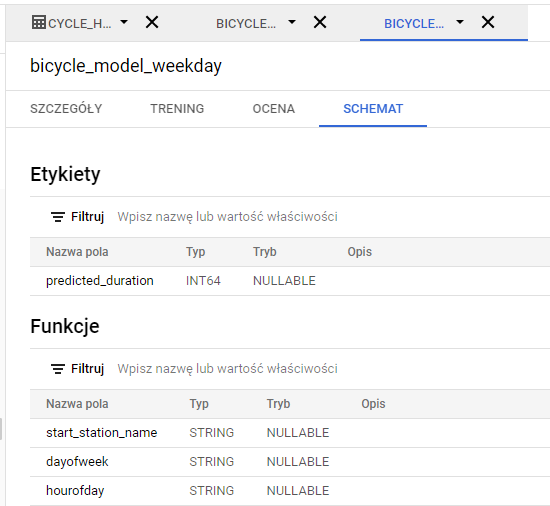

- Model daje `średni bezwzględny błąd` wynoszący 967 sekund, czyli mniej niż 1026 sekund dla oryginalnego modelu.
- Przejdźmy więc do modelu weekendu w dni powszednie.
- Model nr 3

In [ ]:
%%bigquery --project empik-ga360

CREATE OR REPLACE MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`
OPTIONS(
    input_label_cols=['duration'],
    model_type='linear_reg')
AS

SELECT
    duration
    , start_station_name
    , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6, 'weekday', 'weekend')
    as dayofweek
    , ML.BUCKETIZE(EXTRACT(hour FROM start_date), [5, 10, 17]) AS hourofday
FROM `bigquery-public-data.london_bicycles.cycle_hire`

""


- `ML.BUCKETIZE` przykład funkcji przetwarzania wstępnego obsługiwanej przez BigQuery — przekazujemy liczbę do wiaderkowania i granice pojemników z założeniem, że –infinity i +infinity znajdują się na dowolnym krańcu.
- Ten model daje średni błąd bezwzględny 901 sekund, czyli mniej niż 967 sekund dla modelu dzień-weekend. Wybierzmy więc model kubełkowy.  

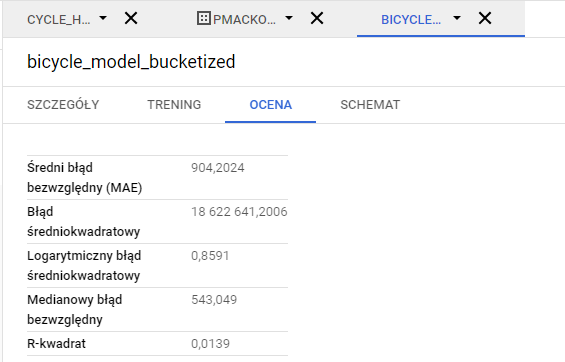

- Przewiduje czas wynajmu w Hyde Parku o godzinie 17:00 we wtorek na podstawie kodu:

In [ ]:
%%bigquery --project empik-ga360

CREATE OR REPLACE MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`
TRANSFORM(* EXCEPT(start_date)
         , IF(EXTRACT(dayofweek FROM start_date) BETWEEN 2 and 6,
'weekday', 'weekend') as dayofweek
         , ML.BUCKETIZE(EXTRACT(HOUR FROM start_date), [5, 10, 17]) AS hourofday
)
OPTIONS(
    input_label_cols=['duration'],
    model_type='linear_reg')
AS

SELECT
  duration
  , start_station_name
  , start_date
FROM `bigquery-public-data.london_bicycles.cycle_hire`

In [ ]:
%%bigquery --project empik-ga360

SELECT * FROM ML.PREDICT(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`,
  (SELECT 'Park Lane , Hyde Park' AS start_station_name
           , CURRENT_TIMESTAMP() AS start_date)
)

,predicted_duration,start_station_name,start_date
0,2901.006158,"Park Lane , Hyde Park",2022-01-23 12:29:55.073602+00:00


- Generowanie prognoz wsadowych (ok 20 k prognoz)

In [ ]:
%%bigquery --project empik-ga360

DECLARE tomorrow_3am TIMESTAMP; # To jest inicjalizacja zmiennej jako TIMESTAMP

SET tomorrow_3am = TIMESTAMP_ADD(TIMESTAMP(DATE_ADD(CURRENT_DATE(), INTERVAL 1 DAY)),INTERVAL 3 HOUR);

WITH generated AS (
  SELECT
    name AS start_station_name
    , GENERATE_TIMESTAMP_ARRAY(
        tomorrow_3am,
        TIMESTAMP_ADD(tomorrow_3am, INTERVAL 24 HOUR),
        INTERVAL 1 HOUR) AS dates
  FROM
    `bigquery-public-data`.london_bicycles.cycle_stations
),

features AS (
  SELECT
    start_station_name
    , start_date
  FROM
    generated
    , UNNEST(dates) AS start_date
)

SELECT * FROM ML.PREDICT(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`,
  (SELECT * FROM features)
)

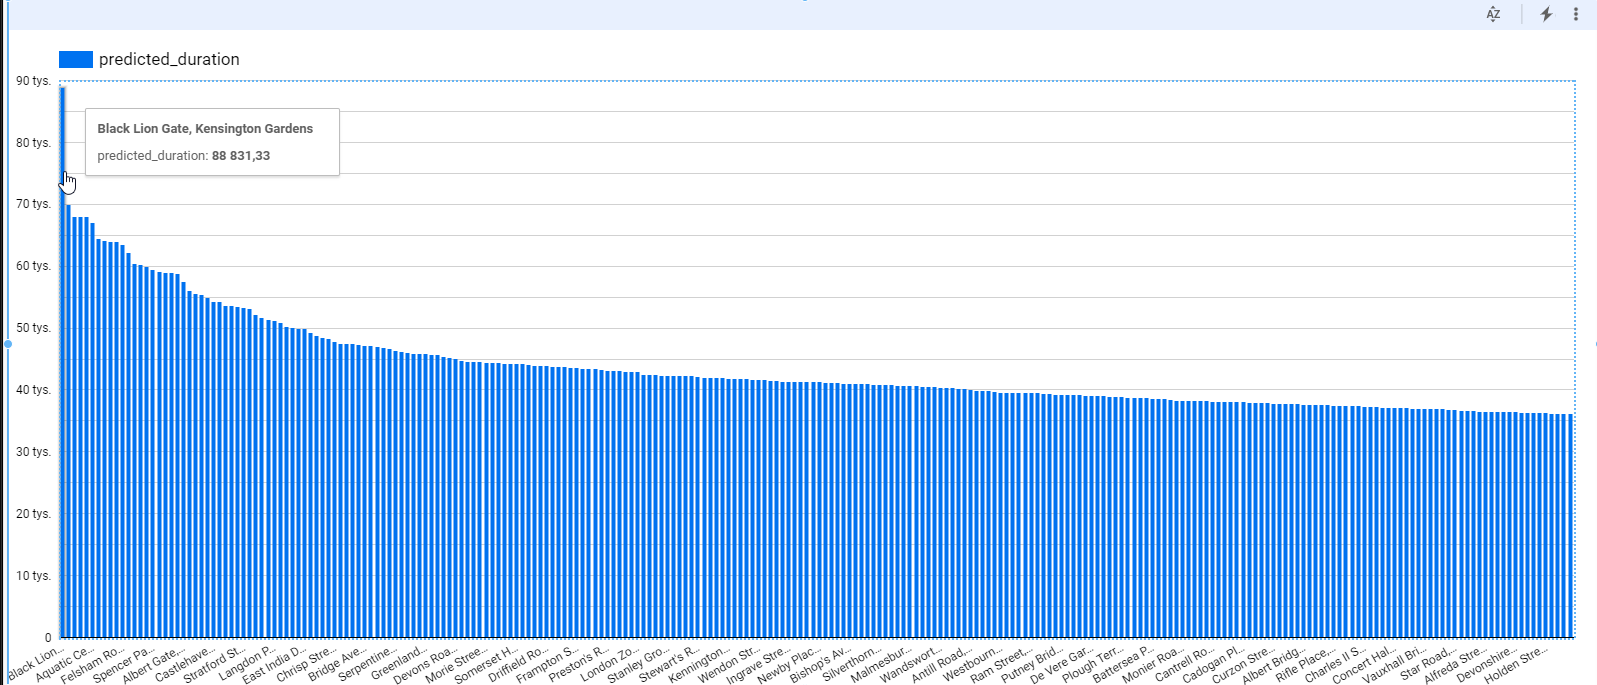

- Model regresji liniowej przewiduje dane wyjściowe jako ważoną sumę danych wejściowych. Sprawdzam te wagi za pomocą kodu:

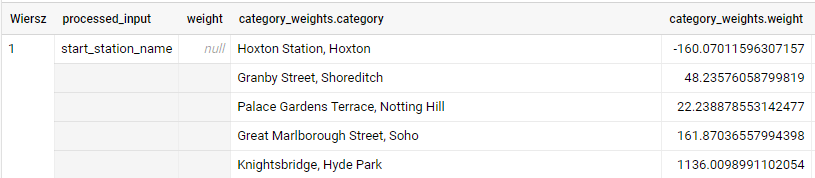

In [ ]:
%%bigquery --project empik-ga360

 SELECT * FROM ML.WEIGHTS(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`)

,processed_input,weight,category_weights
0,start_station_name,NaN,"[{'category': 'Hoxton Station, Hoxton', 'weigh..."
1,dayofweek,NaN,"[{'category': 'weekend', 'weight': 4.455796050..."
2,hourofday,NaN,"[{'category': 'bin_3', 'weight': -2474.9686565..."
3,__INTERCEPT__,4043.233661,[]


In [ ]:
%%bigquery --project empik-ga360

 SELECT
  processed_input AS input,
  model.weight AS input_weight
FROM
  ml.WEIGHTS(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`) AS model

,input,input_weight
0,start_station_name,NaN
1,dayofweek,NaN
2,hourofday,NaN
3,__INTERCEPT__,4043.233661


In [ ]:
%%bigquery --project empik-ga360

  SELECT
  input, min, max, mean, stddev
FROM
  ml.FEATURE_INFO(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`) AS model

,input,min,max,mean,stddev
0,start_station_name,NaN,NaN,NaN,NaN
1,start_date,1.420330e+09,1.497398e+09,1.459483e+09,2.200942e+07


- Dla wag kategorycznych:

In [ ]:
%%bigquery --project empik-ga360

  SELECT
  processed_input AS input,
  model.weight AS input_weight,
  category.category AS category_name,
  category.weight AS category_weight
FROM
  ml.WEIGHTS(MODEL `empik-ga360.pmackowka_other_analyzes.bicycle_model_bucketized`) AS model,
  UNNEST(category_weights) AS category

,input,input_weight,category_name,category_weight
0,start_station_name,None,"Hoxton Station, Hoxton",-160.070116
1,start_station_name,None,"Granby Street, Shoreditch",48.235761
2,start_station_name,None,"Palace Gardens Terrace, Notting Hill",22.238879
3,start_station_name,None,"Great Marlborough Street, Soho",161.870366
4,start_station_name,None,"Knightsbridge, Hyde Park",1136.009899
...,...,...,...,...
881,dayofweek,None,weekday,-374.950354
882,hourofday,None,bin_3,-2474.968657
883,hourofday,None,bin_1,-1877.174606
884,hourofday,None,bin_4,-2610.713040
